In [1]:
import tensorflow as  tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Attention
import os
import cv2
import numpy as np
from random import shuffle
import pandas as pd
from sklearn.preprocessing import  LabelEncoder

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
data_file_path = "/content/drive/My Drive/train_test/merged_data.csv"
lbl_file_path = "/content/drive/My Drive/train_test/merged_lables.csv"
image_width = 28
image_height = 28

In [4]:
original_data=[]

read_img = pd.read_csv(data_file_path)
read1 = read_img.iloc[:,:].values
img_data=np.array(read1)
img_data = read1.reshape(np.shape(img_data)[0],image_width,image_height)
print(np.shape(img_data))

read_img_lbl = pd.read_csv(lbl_file_path)
read2 = read_img_lbl.iloc[:,:].values
img_data_lbl = np.array(read2)
print(np.shape(img_data_lbl))

encoder = LabelEncoder()
transformed_label=[encoder.fit_transform([img_data_lbl[i] for i in range(0,np.shape(img_data_lbl)[0])])]
img_data_lbl = encoder.fit_transform([img_data_lbl[i] for i in range(0,np.shape(img_data_lbl)[0])])


for i in range(np.shape(img_data)[0]):
  original_data.append([img_data[i],img_data_lbl[i]]) 

shuffle(original_data)
np.shape(original_data)

(2922, 28, 28)
(2922, 1)


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(2922, 2)

In [5]:
train_data = original_data[0:int(np.shape(original_data)[0]*0.7)]
test_data = original_data[int(np.shape(original_data)[0]*0.7) : ]

print(np.shape(train_data))
print(np.shape(test_data))

X_train = np.array([train_data[i][0] for i in range(0,np.shape(train_data)[0])]).reshape(-1,image_width,image_height,)
X_test =  np.array([test_data[i][0] for i in range(0,np.shape(test_data)[0])]).reshape(-1,image_width,image_height,)

print(np.shape(X_train))
print(np.shape(X_test))

Y_train =np.array([train_data[i][1] for i in range(0,np.shape(train_data)[0])])
Y_test = np.array([test_data[i][1] for i in range(0,np.shape(test_data)[0])])
#Y_test = to_categorical(Y_test)

print(np.shape(Y_train))
print(np.shape(Y_test))

(2045, 2)
(877, 2)
(2045, 28, 28)
(877, 28, 28)
(2045,)
(877,)


In [6]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255.0
X_test /= 255.0

print(np.shape(X_train))
print(np.shape(Y_train))

(2045, 28, 28)
(2045,)


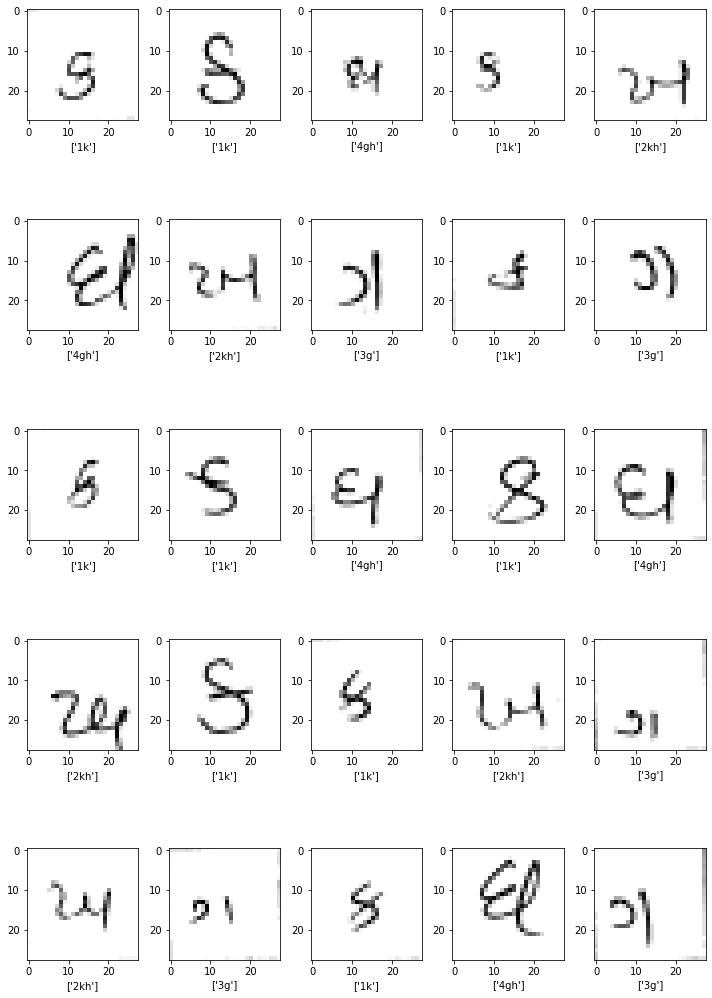

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 15))

for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.grid(False)
    plt.imshow(train_data[i][0], cmap=plt.cm.binary)
    plt.xlabel(encoder.inverse_transform([train_data[i][1]]))
plt. tight_layout()
plt.show()

In [8]:
print(X_train[1:].shape)

(2044, 28, 28)


In [9]:
from tensorflow.keras.layers import Dense, Lambda, dot, Activation, concatenate
from tensorflow.keras.layers import Layer


class Attention(Layer):

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def __call__(self, hidden_states):
        hidden_size = int(hidden_states.shape[2])
        # Inside dense layer
        #              hidden_states            dot               W            =>           score_first_part
        # (batch_size, time_steps, hidden_size) dot (hidden_size, hidden_size) => (batch_size, time_steps, hidden_size)
        # W is the trainable weight matrix of attention Luong's multiplicative style score
        score_first_part = Dense(hidden_size, use_bias=False, name='attention_score_vec')(hidden_states)
        #            score_first_part           dot        last_hidden_state     => attention_weights
        # (batch_size, time_steps, hidden_size) dot   (batch_size, hidden_size)  => (batch_size, time_steps)
        h_t = Lambda(lambda x: x[:, -1, :], output_shape=(hidden_size,), name='last_hidden_state')(hidden_states)
        score = dot([score_first_part, h_t], [2, 1], name='attention_score')
        attention_weights = Activation('softmax', name='attention_weight')(score)
        # (batch_size, time_steps, hidden_size) dot (batch_size, time_steps) => (batch_size, hidden_size)
        context_vector = dot([hidden_states, attention_weights], [1, 1], name='context_vector')
        pre_activation = concatenate([context_vector, h_t], name='attention_output')
        attention_vector = Dense(128, use_bias=False, activation='tanh', name='attention_vector')(pre_activation)
        return attention_vector

In [11]:
model = Sequential()
model.add(LSTM(128, input_shape= (X_train.shape[1:]), activation='relu', return_sequences=True))
model.add(Dropout(0.2))

model.add(Attention(name='attention_weight'))
model.add(Dropout(0.2))

#model.add(LSTM(128, activation='relu'))
#model.add(Dropout(0.2))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(10, activation='softmax'))

IndexError: ignored

In [ ]:
opt = tf.keras.optimizers.Adam(lr=1e-3, decay=1e-5) 

In [ ]:
model.compile(loss='sparse_categorical_crossentropy', optimizer=opt,
             metrics=['accuracy'])

In [ ]:
model.fit(X_train, Y_train, epochs=20, validation_data=(X_test, Y_test))

Epoch 1/20
64/64 [==============================] - 3s 42ms/step - loss: 0.0041 - accuracy: 0.9995 - val_loss: 0.3453 - val_accuracy: 0.9590
Epoch 2/20
64/64 [==============================] - 3s 41ms/step - loss: 0.0160 - accuracy: 0.9936 - val_loss: 0.3730 - val_accuracy: 0.9544
Epoch 3/20
64/64 [==============================] - 3s 42ms/step - loss: 0.0242 - accuracy: 0.9961 - val_loss: 0.4720 - val_accuracy: 0.9293
Epoch 4/20
64/64 [==============================] - 3s 40ms/step - loss: 0.0822 - accuracy: 0.9790 - val_loss: 0.2636 - val_accuracy: 0.9396
Epoch 5/20
64/64 [==============================] - 3s 42ms/step - loss: 0.0456 - accuracy: 0.9897 - val_loss: 0.2344 - val_accuracy: 0.9418
Epoch 6/20
64/64 [==============================] - 3s 41ms/step - loss: 0.0196 - accuracy: 0.9946 - val_loss: 0.3102 - val_accuracy: 0.9430
Epoch 7/20
64/64 [==============================] - 3s 40ms/step - loss: 0.0227 - accuracy: 0.9946 - val_loss: 0.2512 - val_accuracy: 0.9475
Epoch 8/20
64

In [ ]:
test_loss, test_acc = model.evaluate(X_test, Y_test, verbose=2)
print(f'\nTest accuracy: {test_acc*100}')

28/28 - 0s - loss: 0.3953 - accuracy: 0.9544

Test accuracy: 95.43899893760681


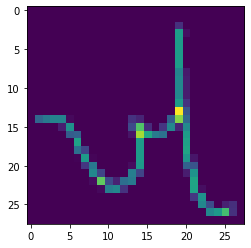

<class 'numpy.ndarray'>
(28, 28)


In [ ]:
filename ="/content/drive/My Drive/train_test/2.JPG" 

img = cv2.imread(filename)

# converting to grey scakle img
grey = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# thresholded img
thr = cv2.threshold(grey, 250, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

#erode and dilate
kernel = np.ones((5, 5), np.uint8)
erode = cv2.erode(thr, kernel, iterations=1)
dilate = cv2.dilate(erode, kernel, iterations=1)

# resize image
width = image_width
height = image_height
dim = (width, height)
resized = cv2.resize(dilate, dim, interpolation=cv2.INTER_AREA)

# REMOVE NOISE
noise = cv2.medianBlur(resized, 1)


# inverted img
invert = cv2.bitwise_not(noise)

plt.imshow(invert)
plt.show()
data=np.array
data = np.asarray(invert)
print(type(data))
print(data.shape)
data = data.astype('float32')
data /= 255.0

In [ ]:
example = data
prediction = model.predict(example.reshape(-1,image_width,image_height))
hard_maxed_prediction = np.zeros(prediction.shape)
hard_maxed_prediction[0][np.argmax(prediction)] = 1
print (hard_maxed_prediction[0])
print(encoder.inverse_transform([np.argmax(prediction[0])]))

[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
['2kh']
